In [59]:
import pickle
import itertools
import os.path as op
from glob import glob

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

In [60]:
result_dir = op.abspath("../results")
dec_data_dir = op.join(result_dir, "gradient_decoding")

In [86]:
hue_order = [
    'term_neurosynth_Percentile',
    'term_neuroquery_Percentile',
    'term_neurosynth_KMeans', 
    "term_neuroquery_KMeans", 
    "term_neurosynth_KDE", 
    "term_neuroquery_KDE",
    'lda_neurosynth_Percentile',
    'lda_neuroquery_Percentile',
    'lda_neurosynth_KMeans', 
    "lda_neuroquery_KMeans", 
    "lda_neurosynth_KDE", 
    "lda_neuroquery_KDE",
    'gclda_neurosynth_Percentile',
    'gclda_neuroquery_Percentile',
    'gclda_neurosynth_KMeans', 
    "gclda_neuroquery_KMeans", 
    "gclda_neurosynth_KDE", 
    "gclda_neuroquery_KDE",
]

In [61]:

n_seg = 1
methods = ["Percentile", "KMeans", "KDE"]
dset_names = ["neurosynth", "neuroquery"]
models = ["term", "lda", "gclda"]

method_nm_lst = []
seg_sol_lst = []
corr_val_lst = []
seg_sols = [f"{seg + 3:02d}" for seg in range(n_seg)]
for seg_sol in seg_sols:
    data_df = pd.DataFrame()
    for dset_name, model, method in itertools.product(dset_names, models, methods):
        corr_dir = op.join(dec_data_dir, f"{model}_{dset_name}_corr_{method}")
        corr_file = op.join(corr_dir, f"{seg_sol}_corr.npy")
        corr_arr = np.load(corr_file)

        n_elements = corr_arr.shape[0] * corr_arr.shape[1]
        method_nm_lst.append([f"{model}_{dset_name}_{method}"] * n_elements)
        seg_sol_sub = [[str(id+1)] * corr_arr.shape[1] for id in range(int(seg_sol))]
        seg_sol_lst.append(np.hstack(seg_sol_sub))
        corr_val_lst.append(corr_arr.flatten())
    
    method_nm_arr = np.hstack(method_nm_lst)
    seg_sol_arr = np.hstack(seg_sol_lst)
    corr_val_arr = np.hstack(corr_val_lst)

    data_df["method"] = method_nm_arr
    data_df["seg_sol"] = seg_sol_arr
    data_df["corr"] = corr_val_arr
    print(data_df)
    

                           method seg_sol      corr
0      term_neurosynth_Percentile       1  0.215554
1      term_neurosynth_Percentile       1  0.091610
2      term_neurosynth_Percentile       1  0.318514
3      term_neurosynth_Percentile       1  0.070797
4      term_neurosynth_Percentile       1  0.207412
...                           ...     ...       ...
91552        gclda_neuroquery_KDE       3 -0.091562
91553        gclda_neuroquery_KDE       3 -0.014256
91554        gclda_neuroquery_KDE       3  0.095816
91555        gclda_neuroquery_KDE       3 -0.142258
91556        gclda_neuroquery_KDE       3  0.011997

[91557 rows x 3 columns]


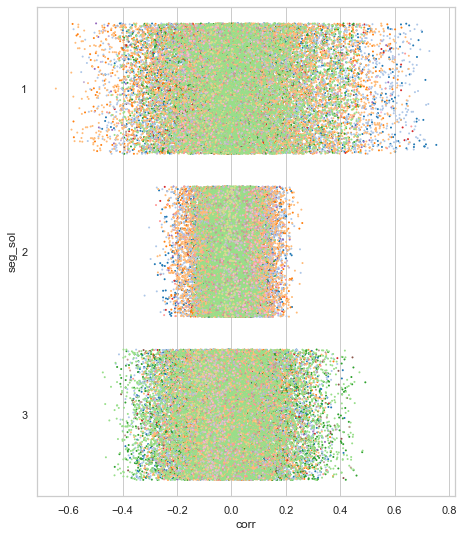

In [88]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7.5, 9)

sns.stripplot(
    data=data_df, 
    x="corr", 
    y="seg_sol", 
    hue="method", 
    jitter=0.4, 
    size=2, 
    ax=ax, 
    palette="tab20",
    hue_order=hue_order,    
)
plt.legend([],[], frameon=False)

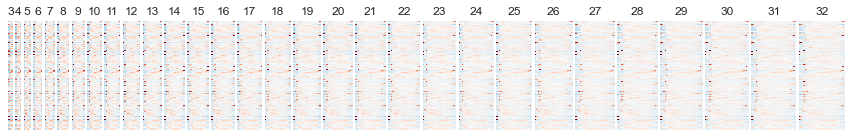

In [26]:

corrs_seg_fn = op.join(result_dir, "gradient_decoding", "gclda_corrs_segments.pkl")
corrs_segments_file = open(corrs_seg_fn, "rb")
corrs_seg_dict = pickle.load(corrs_segments_file)
sns.set(style="whitegrid")

segment_sizes = [corrs_seg.shape[1] for corrs_seg in corrs_seg_dict["kmeans_grad_segments"]]
segment_sizes = [segment_size/np.min(segment_sizes) for segment_size in segment_sizes]

n_segmentations = len(corrs_seg_dict["kmeans_grad_segments"])
# gs = gridspec.GridSpec(1, n_segmentations, width_ratios=segment_sizes)

fig, axes = plt.subplots(1, n_segmentations, gridspec_kw={'width_ratios': segment_sizes})
fig.set_size_inches(15, 2)

for segmentation_i in range(n_segmentations):
    sns.heatmap(
        corrs_seg_dict["kmeans_grad_segments"][segmentation_i], 
        cmap="RdBu_r", 
        square=False, 
        cbar=False,
        center=0,
        vmin=-0.1, vmax=0.3,
        ax=axes[segmentation_i],
    )
    axes[segmentation_i].set_yticklabels([])
    axes[segmentation_i].set_xticklabels([])
    axes[segmentation_i].set_title(f"{segmentation_i + 3}")

plt.subplots_adjust(wspace=0.1)
# fig.tight_layout()
plt.savefig(op.join("./Fig", "corr_matrices.eps"), bbox_inches="tight")
plt.show()
